In [ ]:
!git clone https://github.com/sigango/VAE_MNIST.git

Cloning into 'VAE_MNIST'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [ ]:
!ls -a
%cd

.	 cuda-keyring_1.0-1_all.deb  home    libx32		       proc  sys	var
..	 datalab		     kaggle  media		       root  tmp
bin	 dev			     lib     mnt		       run   tools
boot	 .dockerenv		     lib32   NGC-DL-CONTAINER-LICENSE  sbin  usr
content  etc			     lib64   opt		       srv   VAE_MNIST
/root


# Load the library

In [1]:
!pip install torch torchvision medmnist
!pip install --upgrade matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
#Import the lib
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
# Initialize VAE model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

Using device: cuda:0


# Pre-processing the Data

In [5]:
#MedMNIST dataset (Pathology test)
data_flag = 'pathmnist'
download = True

#dataset info
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
print(info)

# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load datasets
train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

{'python_class': 'PathMNIST', 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.', 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1', 'MD5': 'a8b06965200029087d5bd730944a56c1', 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1', 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616', 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1', 'MD5_128': 

100%|██████████| 205615438/205615438 [00:10<00:00, 19313148.38it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz


# VAE Architecture setup

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        x_hat = self.sigmoid(self.fc2(h))
        return x_hat

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    def loss_function(self, x_hat, x, mu, logvar):
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div


In [7]:
# model parameters
input_dim = 28 * 28  # images are 28x28 pixels
hidden_dim = 400
latent_dim = 20

vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# normalized to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset = DataClass(split='test', transform=transform, download=download)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
# Training
num_epochs = 200
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)

        # data in the range [0, 1]
        data = (data + 1) / 2
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(data)

        # x_hat in the range [0, 1]
        x_hat = (x_hat + 1) / 2

        loss = vae.loss_function(x_hat, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch: {epoch}, Train_loss: {train_loss}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch: 0, Train_loss: 130787389.54882812, Loss: 1453.2578064450433
Epoch: 1, Train_loss: 128320261.37109375, Loss: 1425.8440527478303
Epoch: 2, Train_loss: 127971824.84375, Loss: 1421.9723637022757
Epoch: 3, Train_loss: 127897852.44335938, Loss: 1421.1504116111757
Epoch: 4, Train_loss: 127855254.75976562, Loss: 1420.6770829788616
Epoch: 5, Train_loss: 127760629.10546875, Loss: 1419.6256400892123
Epoch: 6, Train_loss: 127789709.82617188, Loss: 1419.9487735696239
Epoch: 7, Train_loss: 127711809.89648438, Loss: 1419.0831803245076
Epoch: 8, Train_loss: 127744424.47265625, Loss: 1419.4455806108745
Epoch: 9, Train_loss: 127704546.95507812, Loss: 1419.002477388752
Epoch: 10, Train_loss: 127647494.1640625, Loss: 1418.3685293131084
Epoch: 11, Train_loss: 127661392.65820312, Loss: 1418.522963889541
Epoch: 12, Train_loss: 127655985.2421875, Loss: 1418.4628788189198
Epoch: 13, Train_loss: 127624886.65234375, Loss: 1418.117323573756
Epoch: 14, Train_loss: 127635576.97851562, Loss: 1418.236110255073

In [ ]:
# num_epochs = 10
# for epoch in range(num_epochs):
#     vae.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.view(-1, input_dim).to(device)
#         print(f'Input data shape: {data.shape}, min: {data.min()}, max: {data.max()}')

#         optimizer.zero_grad()

#         x_hat, mu, logvar = vae(data)
#         print(f'Reconstructed data shape: {x_hat.shape}, min: {x_hat.min()}, max: {x_hat.max()}')

#         loss = vae.loss_function(x_hat, data, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#     print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

# Evaluating the reconstructed images

In [ ]:
from medmnist import Evaluator

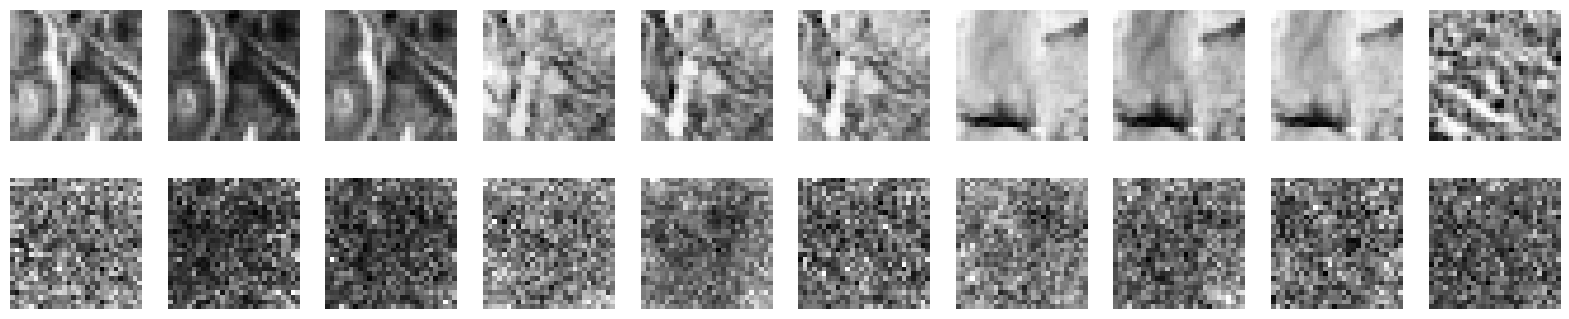

In [ ]:
vae.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.view(-1, input_dim).to(device)
    x_hat, _, _ = vae(data)
    x_hat = x_hat.view(-1, 1, 28, 28).cpu()

    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))
    for images, row in zip([data.view(-1, 1, 28, 28).cpu(), x_hat], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.numpy().squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

# Visualization the generated images

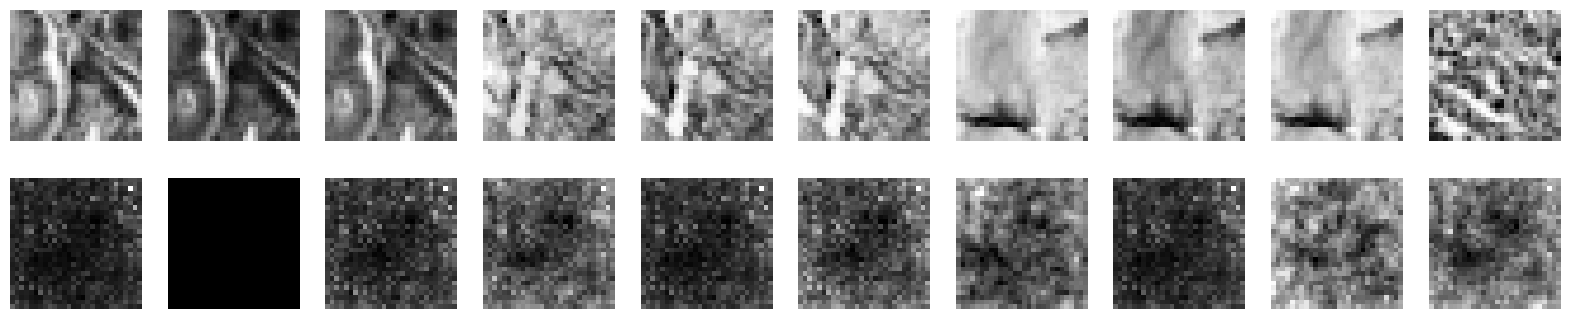

In [ ]:
# with torch.no_grad():
#       data, _ = next(iter(test_loader))
#       data = data.view(-1, input_dim).to(device)
#       x_hat, _, _ = vae(data)
#       x_hat = x_hat.view(-1, 1, 28, 28).cpu()

#       fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))
#       for images, row in zip([data.view(-1, 1, 28, 28).cpu(), x_hat], axes):
#           for img, ax in zip(images, row):
#               ax.imshow(img.numpy().squeeze(), cmap='gray')
#               ax.axis('off')
#       plt.show()

In [ ]:
!git add .
!git commit -m "Add VAE model"
!git push origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
